In [1]:
import sys
import os
sys.path.append('/home/franzi/anzeigendaten/python_base/skillextraktion/fh_ma')
sys.path.append('/home/franzi/anzeigendaten/EnvPython')
import prepare_training_data
from labels import *
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import shuffle

start = time.time()
x_train, y_train, x_test, y_test, test_afks, features = prepare_training_data.get_training_data(berufsgruppen=True, pos=True, word_features=True)
print('took: ',time.time()-start)

20861874
0
skipgram, punctuation_marks, stoppwords, multiword, lower_case, vector_dim True False False False False 100
init /home/franzi/Documents/models/no_pm_no_sw_vecDim100/skip_gram_model.model
loading existing w2v model from  /home/franzi/Documents/models/no_pm_no_sw_vecDim100/skip_gram_model.model
using data from  /home/franzi/Documents/data/data_bg_pos_wFeatures_4_vecDim100
loading data...
37823 37823 12053 12053 0 0
took:  4.018267631530762


In [3]:
import numpy as np
for i,f in enumerate(features):
    features[i] = np.array(f)
pos_test, wf_test, bg_test, pos_train, wf_train, bg_train,  _, _, _ = features

print(wf_train[0]) # Abgeschlossene
print(pos_train[0]) # ADJA first
print(y_train[0])

[[0.         0.         0.         0.         1.         0.
  0.         0.         1.         0.         1.         0.00033559]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
[0. 0. 0. 0. 0. 0. 0. 1.]


In [5]:
from tensorflow.keras import *

In [6]:
wf_test = np.reshape(wf_test, (wf_test.shape[0], wf_test.shape[2]))
wf_train = np.reshape(wf_train, (wf_train.shape[0], wf_train.shape[2]))
pos_test = np.reshape(pos_test, (pos_test.shape[0], pos_test.shape[2]))
pos_train = np.reshape(pos_train, (pos_train.shape[0], pos_train.shape[2]))

In [7]:
# Build the model
print('Build model...')

vector_window_input = layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
vw = layers.LSTM(256, return_sequences=True)(vector_window_input)
vw = layers.Dropout(0.5)(vw)
vw = layers.BatchNormalization()(vw)
vw = layers.LSTM(512, return_sequences=True)(vw)
vw = layers.Dropout(0.5)(vw)
vw = layers.BatchNormalization()(vw)
vw = layers.LSTM(512)(vw)
vw = layers.Dropout(0.5)(vw)
vw = layers.BatchNormalization()(vw)
vw = layers.Dense(128, activation='relu')(vw)

wf_input = layers.Input(shape=(len(wf_train[0])))
f = layers.Dense(512, activation='relu')(wf_input)
f = layers.Dropout(0.5)(f)
f = layers.Dense(256, activation='relu')(f)

pos_input = layers.Input(shape=(len(pos_train[0])))
p = layers.Dense(512, activation='relu')(pos_input)
p = layers.Dropout(0.5)(p)
p = layers.Dense(256, activation='relu')(p)

bg_input = layers.Input(shape=(len(bg_train[0])))
b = layers.Dense(512, activation='relu')(bg_input)
b = layers.Dropout(0.5)(b)
b = layers.Dense(256, activation='relu')(b)

x = layers.concatenate([vw, f, p, b])
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)

out = layers.Dense(units=len(labels), activation='softmax')(x)
all_model = models.Model(inputs=[vector_window_input, wf_input, pos_input, bg_input], outputs=[out])

all_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

all_model.evaluate(x=[x_test, wf_test, pos_test, bg_test], y=y_test)

batch_size=32
history = all_model.fit([x_train, wf_train, pos_train, bg_train], y_train, batch_size=batch_size, shuffle=True, epochs=5, validation_data=([x_test, wf_test, pos_test, bg_test], y_test))

2020-08-22 17:01:03 WARNING: From /home/franzi/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Build model...
12053/12053 [==============================] - 23s 2ms/sample - loss: 2.1025 - acc: 0.0495
Train on 37823 samples, validate on 12053 samples


2020-08-22 17:01:30 WARNING: From /home/franzi/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
37823/37823 [==============================] - 191s 5ms/sample - loss: 0.7788 - acc: 0.7179 - val_loss: 0.7376 - val_acc: 0.7153
Epoch 2/5
37823/37823 [==============================] - 188s 5ms/sample - loss: 0.5956 - acc: 0.7828 - val_loss: 0.5350 - val_acc: 0.8092
Epoch 3/5
37823/37823 [==============================] - 190s 5ms/sample - loss: 0.4818 - acc: 0.8286 - val_loss: 0.4571 - val_acc: 0.8400
Epoch 4/5
37823/37823 [==============================] - 192s 5ms/sample - loss: 0.4325 - acc: 0.8469 - val_loss: 0.4602 - val_acc: 0.8380
Epoch 5/5
37823/37823 [==============================] - 191s 5ms/sample - loss: 0.4023 - acc: 0.8605 - val_loss: 0.4343 - val_acc: 0.8527


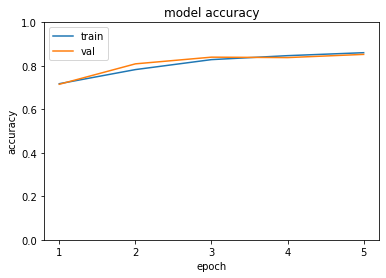

In [8]:
from matplotlib import pyplot as plt
plt.plot(np.arange(1, len(history.history['acc'])+1), history.history['acc'])
plt.plot(np.arange(1, len(history.history['acc'])+1), history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.xticks(np.arange(1, len(history.history['acc'])+1))
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [9]:

# predict test data
all_y_pred = all_model.predict([x_test, wf_test, pos_test, bg_test])
all_pred_label = prepare_training_data.one_hot_to_labels(all_y_pred)

In [ ]:
import numpy as np
# convert one hot to labels for test data
true_label = prepare_training_data.one_hot_to_labels(y_test)

In [11]:
# Build the model
print('Build model...')
lstm_model = Sequential()
lstm_model.add(layers.LSTM(256, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
lstm_model.add(layers.BatchNormalization())
lstm_model.add(layers.Dropout(0.5))
lstm_model.add(layers.LSTM(512, return_sequences=True))
lstm_model.add(layers.Dropout(0.5))
lstm_model.add(layers.BatchNormalization())
lstm_model.add(layers.LSTM(256))
lstm_model.add(layers.Dropout(0.5))
lstm_model.add(layers.Dense(256))
lstm_model.add(layers.Dense(units=len(labels)))
lstm_model.add(layers.Activation('softmax'))
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

batch_size=32
history = lstm_model.fit(x_train, y_train, batch_size=batch_size, shuffle=True, epochs=5, validation_data=(x_test, y_test))

Build model...
Train on 37823 samples, validate on 12053 samples
Epoch 1/5
37823/37823 [==============================] - 139s 4ms/sample - loss: 0.8417 - acc: 0.6888 - val_loss: 0.6047 - val_acc: 0.7700
Epoch 2/5
37823/37823 [==============================] - 136s 4ms/sample - loss: 0.5330 - acc: 0.8106 - val_loss: 0.5327 - val_acc: 0.8088
Epoch 3/5
37823/37823 [==============================] - 136s 4ms/sample - loss: 0.4642 - acc: 0.8361 - val_loss: 0.4458 - val_acc: 0.8482
Epoch 4/5
37823/37823 [==============================] - 137s 4ms/sample - loss: 0.4268 - acc: 0.8497 - val_loss: 0.4730 - val_acc: 0.8413
Epoch 5/5
37823/37823 [==============================] - 136s 4ms/sample - loss: 0.3989 - acc: 0.8614 - val_loss: 0.4302 - val_acc: 0.8505


In [12]:
# predict test data
lstm_y_pred = lstm_model.predict([x_test])
lstm_pred_label = prepare_training_data.one_hot_to_labels(lstm_y_pred)

In [13]:
# Build the model
print('Build model...')

vector_window_input = layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
vw = layers.LSTM(256, return_sequences=True)(vector_window_input)
vw = layers.Dropout(0.5)(vw)
vw = layers.BatchNormalization()(vw)
vw = layers.LSTM(512, return_sequences=True)(vw)
vw = layers.Dropout(0.5)(vw)
vw = layers.BatchNormalization()(vw)
vw = layers.LSTM(512)(vw)
vw = layers.Dropout(0.5)(vw)
vw = layers.BatchNormalization()(vw)
vw = layers.Dense(128, activation='relu')(vw)

pos_input = layers.Input(shape=(len(pos_train[0])))
p = layers.Dense(512, activation='relu')(pos_input)
p = layers.Dropout(0.5)(p)
p = layers.Dense(256, activation='relu')(p)

x = layers.concatenate([vw, p])
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)

out = layers.Dense(units=len(labels), activation='softmax')(x)
pos_model = models.Model(inputs=[vector_window_input, pos_input], outputs=[out])

pos_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

pos_model.evaluate(x=[x_test, pos_test], y=y_test)

batch_size=32
history = pos_model.fit([x_train, pos_train], y_train, batch_size=batch_size, shuffle=True, epochs=5, validation_data=([x_test, pos_test], y_test))

Build model...
12053/12053 [==============================] - 23s 2ms/sample - loss: 2.0574 - acc: 0.5846
Train on 37823 samples, validate on 12053 samples
Epoch 1/5
37823/37823 [==============================] - 201s 5ms/sample - loss: 0.8270 - acc: 0.6871 - val_loss: 0.8031 - val_acc: 0.6825
Epoch 2/5
37823/37823 [==============================] - 195s 5ms/sample - loss: 0.6458 - acc: 0.7615 - val_loss: 0.5475 - val_acc: 0.8082
Epoch 3/5
37823/37823 [==============================] - 191s 5ms/sample - loss: 0.5014 - acc: 0.8237 - val_loss: 0.4840 - val_acc: 0.8345
Epoch 4/5
37823/37823 [==============================] - 189s 5ms/sample - loss: 0.4496 - acc: 0.8439 - val_loss: 0.4794 - val_acc: 0.8328
Epoch 5/5
37823/37823 [==============================] - 189s 5ms/sample - loss: 0.4233 - acc: 0.8518 - val_loss: 0.4368 - val_acc: 0.8522


In [14]:
# predict test data
pos_y_pred = pos_model.predict([x_test, pos_test])
pos_pred_label = prepare_training_data.one_hot_to_labels(pos_y_pred)

In [15]:
# Build the model
print('Build model...')

vector_window_input = layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
vw = layers.LSTM(256, return_sequences=True)(vector_window_input)
vw = layers.Dropout(0.5)(vw)
vw = layers.BatchNormalization()(vw)
vw = layers.LSTM(512, return_sequences=True)(vw)
vw = layers.Dropout(0.5)(vw)
vw = layers.BatchNormalization()(vw)
vw = layers.LSTM(512)(vw)
vw = layers.Dropout(0.5)(vw)
vw = layers.BatchNormalization()(vw)
vw = layers.Dense(128, activation='relu')(vw)

wf_input = layers.Input(shape=(len(wf_train[0])))
f = layers.Dense(512, activation='relu')(wf_input)
f = layers.Dropout(0.5)(f)
f = layers.Dense(256, activation='relu')(f)

x = layers.concatenate([vw, f])
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)

out = layers.Dense(units=len(labels), activation='softmax')(x)
wf_model = models.Model(inputs=[vector_window_input, wf_input], outputs=[out])

wf_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

wf_model.evaluate(x=[x_test, wf_test], y=y_test)

batch_size=32
history = wf_model.fit([x_train, wf_train], y_train, batch_size=batch_size, shuffle=True, epochs=5, validation_data=([x_test, wf_test], y_test))

Build model...
12053/12053 [==============================] - 23s 2ms/sample - loss: 2.0580 - acc: 0.2658
Train on 37823 samples, validate on 12053 samples
Epoch 1/5
37823/37823 [==============================] - 191s 5ms/sample - loss: 0.7857 - acc: 0.7138 - val_loss: 0.9248 - val_acc: 0.6081
Epoch 2/5
37823/37823 [==============================] - 187s 5ms/sample - loss: 0.6115 - acc: 0.7756 - val_loss: 0.5180 - val_acc: 0.8206
Epoch 3/5
37823/37823 [==============================] - 187s 5ms/sample - loss: 0.4881 - acc: 0.8267 - val_loss: 0.4688 - val_acc: 0.8346
Epoch 4/5
37823/37823 [==============================] - 187s 5ms/sample - loss: 0.4463 - acc: 0.8438 - val_loss: 0.4349 - val_acc: 0.8494
Epoch 5/5
37823/37823 [==============================] - 188s 5ms/sample - loss: 0.4083 - acc: 0.8575 - val_loss: 0.4309 - val_acc: 0.8463


In [16]:
# predict test data
wf_y_pred = wf_model.predict([x_test, wf_test])
wf_pred_label = prepare_training_data.one_hot_to_labels(wf_y_pred)

In [17]:
pred_label = []
for i in range(len(x_test)):
    items = [lstm_pred_label[i], all_pred_label[i], pos_pred_label[i], wf_pred_label[i]]
    stats = {}
    for j in items:
        if j in stats:
            stats[j] += 1
        else:
            stats[j] = 1
    sorted_dict = sorted(stats, key=stats.get, reverse=True)
    top = sorted_dict[0]
    pred_label.append(top)
    

In [18]:
# Calc metrics for test data
import sklearn
from sklearn.metrics import precision_score, recall_score, accuracy_score
from tabulate import tabulate
label_list = list(labels.keys())

headers = [l for l in label_list ]
headers = [' '] + headers

table=[['precision'] + list(precision_score(true_label, pred_label, average=None)), 
       ['recall']+list(recall_score(true_label, pred_label, average=None)), 
       ['f1']+ list(sklearn.metrics.f1_score(true_label, pred_label, average=None))]

print(tabulate(table, headers=headers, tablefmt='orgtbl'))
f1 = sklearn.metrics.f1_score(true_label, pred_label, average=None)
f1 = np.delete(f1, 4)
f1 = np.delete(f1, 6)
print('f1 average: ',sum(sklearn.metrics.f1_score(true_label, pred_label, average=None))/len(list(precision_score(true_label, pred_label, average=None))))
print('f1 average: ',sum(f1)/6)
print('Precision average: ',sum(precision_score(true_label, pred_label, average=None)/8))
print('recall average: ',sum(recall_score(true_label, pred_label, average=None)/8))
print('acc', sklearn.metrics.accuracy_score(true_label, pred_label))

|           |   Ausbildung |    Beruf |   allgemein |   berufsspez |   Sprache |   Technologie |   Softskill |   noSkill |
|-----------+--------------+----------+-------------+--------------+-----------+---------------+-------------+-----------|
| precision |     0.801292 | 0.36     |    0.592593 |     0.668407 |  0.951111 |      0.809859 |    0.771697 |  0.934644 |
| recall    |     0.898551 | 0.28125  |    0.291725 |     0.717757 |  0.968326 |      0.890323 |    0.916435 |  0.92811  |
| f1        |     0.847139 | 0.315789 |    0.390977 |     0.692204 |  0.959641 |      0.848187 |    0.837861 |  0.931365 |
f1 average:  0.7278955131013398
f1 average:  0.655359572976851
Precision average:  0.7362004012742651
recall average:  0.7365594375146876
acc 0.8642661578030366


In [19]:

wf_prob = wf_model.predict([x_test, wf_test])
print(wf_prob[0])
lstm_prob = lstm_model.predict_proba([x_test])
pos_prob = pos_model.predict([x_test, pos_test])
all_prob = all_model.predict([x_test, wf_test, pos_test, bg_test])

[0.00436753 0.00007006 0.00369703 0.00026008 0.00040096 0.00004818
 0.00093063 0.9902255 ]


In [20]:
pred_label2 = []
probabilities = []
for i in range(len(x_test)):
    probs = [0] * len(labels)
    items = [lstm_prob[i], all_prob[i], pos_prob[i], wf_prob[i]]
    stats = {}
    for net in range(len(items)):
        for index in range(len(items[net])):
            probs[index] += items[net][index]
    pred_label2.append(probs.index(max(probs)))

In [21]:


# Calc metrics for test data
import sklearn
from sklearn.metrics import precision_score, recall_score, accuracy_score
from tabulate import tabulate
label_list = list(labels.keys())

headers = [l for l in label_list ]
headers = [' '] + headers

table=[['precision'] + list(precision_score(true_label, pred_label2, average=None)), 
       ['recall']+list(recall_score(true_label, pred_label2, average=None)), 
       ['f1']+ list(sklearn.metrics.f1_score(true_label, pred_label2, average=None))]

print(tabulate(table, headers=headers, tablefmt='orgtbl'))
f1 = sklearn.metrics.f1_score(true_label, pred_label2, average=None)
f1 = np.delete(f1, 4)
f1 = np.delete(f1, 6)
print('f1 average: ',sum(sklearn.metrics.f1_score(true_label, pred_label2, average=None))/len(list(precision_score(true_label, pred_label2, average=None))))
print('f1 average: ',sum(f1)/6)
print('Precision average: ',sum(precision_score(true_label, pred_label2, average=None)/8))
print('recall average: ',sum(recall_score(true_label, pred_label2, average=None)/8))
print('acc', sklearn.metrics.accuracy_score(true_label, pred_label2))

|           |   Ausbildung |    Beruf |   allgemein |   berufsspez |   Sprache |   Technologie |   Softskill |   noSkill |
|-----------+--------------+----------+-------------+--------------+-----------+---------------+-------------+-----------|
| precision |     0.799035 | 0.357143 |    0.678082 |     0.666386 |  0.977064 |      0.824879 |    0.773511 |  0.933052 |
| recall    |     0.900362 | 0.234375 |    0.2777   |     0.739252 |  0.963801 |      0.88129  |    0.916435 |  0.933914 |
| f1        |     0.846678 | 0.283019 |    0.39403  |     0.70093  |  0.970387 |      0.852152 |    0.838929 |  0.933483 |
f1 average:  0.7274510533947363
f1 average:  0.6526230704213666
Precision average:  0.7511441090073845
recall average:  0.7308911268352978
acc 0.8681656019248319


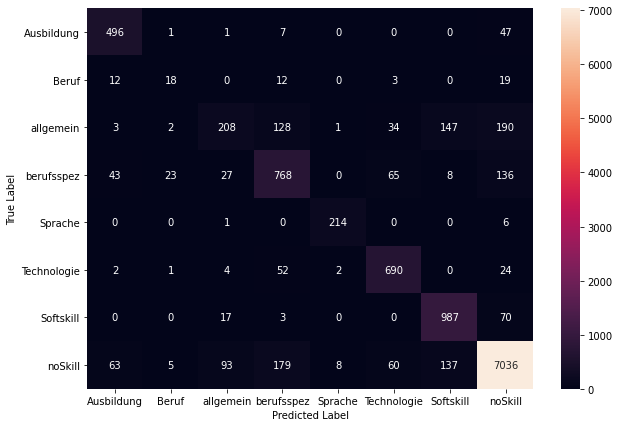

In [22]:
# Create Confusion Matrix

import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = sklearn.metrics.confusion_matrix(true_label, pred_label)
df_cm = pd.DataFrame(cm, labels,columns = labels)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,fmt='g')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [23]:
# clean noSkill for evaluation
clean_y_pred = []
clean_y_test = []
true_noSkills = 0
clean_x_test = []
afks = []

for i in range(len(y_test)):
    if(true_label[i] != 7 or pred_label[i] != 7):
        clean_x_test.append(x_test[i])
        clean_y_pred.append(pred_label[i])
        clean_y_test.append(true_label[i])
        afks.append(test_afks[i])
    else:
        true_noSkills += 1
pred_label = clean_y_pred
true_label = clean_y_test
print('correctly labeled noSkills: ', true_noSkills)

correctly labeled noSkills:  7036


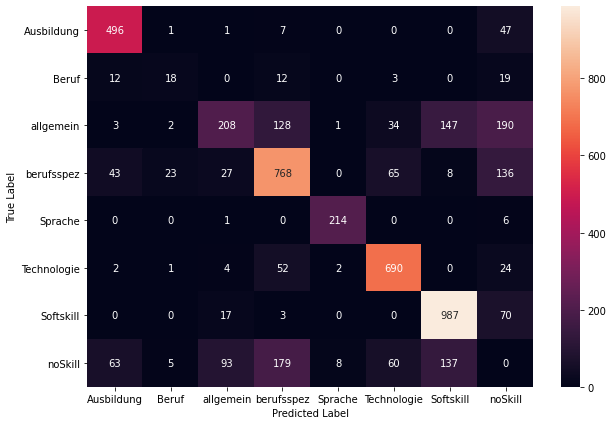

In [24]:
# Create Confusion Matrix

import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = sklearn.metrics.confusion_matrix(true_label, pred_label)
df_cm = pd.DataFrame(cm, labels,columns = labels)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,fmt='g')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [25]:
from word2vec import W2V
correct = []
false = []

clean_x_test, pred_label, true_label, afks = shuffle(clean_x_test, pred_label, true_label, afks,random_state=0)
skill_index = int(len(clean_x_test[0])/2)
label_list = list(labels.keys())


headers = [['|']+[l] for l in label_list ]
headers = sum(headers, [])
headers.append('|')

wvs = []
for i in range(len(clean_x_test)):
    wvs.append(clean_x_test[i][skill_index])

w2v = W2V(skipgram=True, punctuation_marks=False, stoppwords=False, multiword=False, lower_case=False, vector_dim=100)

predictions = [[],[],[],[],[],[],[], []]
for i in range(len(clean_x_test)):
    word = w2v.get_closest_word_to_vec(wvs[i])[0][0]
    label = str(true_label[i])
    predictions[pred_label[i]].append(word + '('+label+')')

table = []
# format
i = 0
while(i < len(predictions[0]) or i < len(predictions[1]) or i < len(predictions[2]) or i < len(predictions[3]) or i < len(predictions[4]) or i < len(predictions[5] or i < len(predictions[6]))):
    row = ['|']
    for x in predictions:
        if(len(x) > i and len(x[i]) <  25): 
            row.append(x[i])
            row.append('|')
        else:
            row.append('')
            row.append('|')
            
    table.append(row)
    i+=1    

print(tabulate(table, headers=headers))

skipgram, punctuation_marks, stoppwords, multiword, lower_case, vector_dim True False False False False 100
init /home/franzi/Documents/models/no_pm_no_sw_vecDim100/skip_gram_model.model
loading existing w2v model from  /home/franzi/Documents/models/no_pm_no_sw_vecDim100/skip_gram_model.model
|    Ausbildung                |    Beruf                     |    allgemein                 |    berufsspez                |    Sprache                   |    Technologie               |    Softskill                 |    noSkill                   |
---  ------------------------  ---  ------------------------  ---  ------------------------  ---  ------------------------  ---  ------------------------  ---  ------------------------  ---  ------------------------  ---  ------------------------  ---
|    Wirtschaftsinformatik(0)  |    Anwendungsentwicklung(3)  |    Technisches(7)            |    Sozialmedizin(3)          |    Deutschkenntnisse(4)      |    HTML(5)                   |    Umgangsformen